In [1]:
# Plot inefficiency against livetime
# Somewhat based on PlotModuleEfficiency and PlotFailures
# Relies on Scripts/SubmitLiveTime.sh and RunLiveTime.sh on the VMs.

In [19]:
# External
# import os
# import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Internal
sys.path.append(os.path.abspath("../PyMacros"))
import Utils as ut
from mu2etools import read_data as rd

In [ ]:
# def PoissonUncertainty(data_):
#     n_failures = np.sum(data_["Failures"])
#     n_total = np.sum(data_["Total"])
#     return np.sqrt(n_failures) / (n_total)

In [76]:
# Get the tags, livetime, efficiency information in a single dataframe. 
# This approach gives the most flexibility
def GetData(tags_, PEs=10, layers=3, particle="all", cut="no_track_cuts", dataset="MDC2020ae"):
    
    print(f"---> Getting data for {len(tags_)} files, {layers}/4 layers, {particle}, {cut}, {dataset}.")

    output_ = pd.DataFrame(columns=["tag", "livetime", "total", "failures", "running_livetime", "running_total", "running_failures"])

    # Get ineffiency data 
    ineffFile =  f"../Txt/{dataset}/AugustCRVMeeting/ThirdPass/concatenated/results/results_{particle}_{PEs}PEs{layers}Layers_{cut}.csv"
    ineffData_ = pd.read_csv(ineffFile)

    # Accumulated results
    runningLiveTime = 0
    runningTotal = 0
    runningFailures = 0
    
    # Iterate through tags
    for tag in tags_:

        # Get live time

        # Read live time file
        liveTimeFile = f"../Txt/{dataset}/LiveTime/mcs.mu2e.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.{tag}.livetime" #  for tag in tags_]
        liveTimeData_ = pd.read_csv(liveTimeFile) 
        # Get total live time
        liveTime = np.sum(liveTimeData_["livetime [s]"])

        # Get inefficiency
        total = ineffData_[ineffData_["Tag"] == tag]["Total"].values[0]
        failures = ineffData_[ineffData_["Tag"] == tag]["Failures"].values[0]

        runningLiveTime += liveTime
        runningTotal += total
        runningFailures += failures
        
        # Append to the DataFrame using .loc
        output_.loc[len(output_)] = [tag, liveTime, total, failures, runningLiveTime, runningTotal, runningFailures]

    return output_

In [22]:
# # Config
# PEs=10
# layers=3
# particle="all"
# cut="no_track_cuts"

In [4]:
# Get file list
defname = "nts.sgrant.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.root"
fileList_ = rd.get_file_list(defname)
# Get tags
tags_ = [ut.ExtractTag(fileName) for fileName in fileList_]

---> Getting file list for nts.sgrant.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.root.
Done!


In [77]:
PEs=10
layers=3
particle="all"
data_no_track_cuts_ = GetData(tags_, PEs=PEs, layers=layers, particle=particle, cut="no_track_cuts")
data_track_cuts_ = GetData(tags_, PEs=PEs, layers=layers, particle=particle, cut="track_cuts")
# print(data_no_track_cuts_)

---> Getting data for 96 files, 3/4 layers, all, no_track_cuts, MDC2020ae.
---> Getting data for 96 files, 3/4 layers, all, track_cuts, MDC2020ae.


In [85]:
def PlotGraphErrors(x, y, xerr=[], yerr=[], title=None, xlabel=None, ylabel=None, colour="blue", fout="scatter.png", NDPI=300):

   # Create a scatter plot with error bars using NumPy arrays 

    # Create figure and axes
    fig, ax = plt.subplots()

    # Plot scatter with error bars
    if len(xerr)==0: xerr = [0] * len(x) # Sometimes we only use yerr
    if len(yerr)==0: yerr = [0] * len(y) # Sometimes we only use yerr

    if len(x) != len(y): print("Warning: x has length", len(x),", while y has length", len(y))

    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', color=colour, markersize=4, ecolor=colour, capsize=2, elinewidth=1, linestyle='None')

    # Add a line at 99.99% efficiency
    if True:
        ax.text(15, 1.05e-4, "99.99% efficiency", color="gray", zorder=1) #, transform=ax.transAxes, ha='right')
        ax.axhline(y=1e-4, color='gray', linestyle='--', zorder=1)
        
    # Set title, xlabel, and ylabel
    ax.set_title(title, fontsize=15, pad=10)
    ax.set_xlabel(xlabel, fontsize=13, labelpad=10) 
    ax.set_ylabel(ylabel, fontsize=13, labelpad=10) 

    # Set font size of tick labels on x and y axes
    ax.tick_params(axis='x', labelsize=13)  # Set x-axis tick label font size
    ax.tick_params(axis='y', labelsize=13)  # Set y-axis tick label font size

    ut.ScientificNotation(ax)

    # Display and save
    plt.tight_layout()
    plt.savefig(fout, dpi=NDPI, bbox_inches="tight")
    plt.show()
    print("---> Written", fout)

    # Clear memory
    plt.close()

In [87]:
def PlotGraphOverlay(graphs_, title=None, xlabel=None, ylabel=None, xmin=0, xmax=-1, ymin=0, ymax=-1, labels_=[], fout="scatter.png", effLine=False, log=False, includeBlack=False, NDPI=300):
    
    # Create figure and axes
    fig, ax = plt.subplots()

    # Iterate over each pair of xy lists
    for i, (label, data_) in enumerate(graphs_.items()):

        colour = ut.colours[i+1]
        if includeBlack: colour = ut.colours[i]

        ax.errorbar(data_["x"], data_["y"], xerr=data_["xerr"], yerr=data_["yerr"], fmt='o', color=colour, markersize=4, ecolor=colour, capsize=2, elinewidth=1, linestyle='-',label=label)

    if log: 
        ax.set_yscale("log")

    # Set title, xlabel, and ylabel
    ax.set_title(title, fontsize=15, pad=10)
    ax.set_xlabel(xlabel, fontsize=13, labelpad=10)
    ax.set_ylabel(ylabel, fontsize=13, labelpad=10)

    # Set font size of tick labels on x and y axes
    ax.tick_params(axis='x', labelsize=13)  
    ax.tick_params(axis='y', labelsize=13)  

    if (ymax > ymin):
        ax.set_ylim(ymin, ymax)

    if (xmax > xmin):
        ax.set_xlim(xmin, xmax)
        
    # Add a line at 99.99% efficiency
    if effLine:
        ax.text(15, 1.05e-4, "99.99% efficiency", color="gray") #, transform=ax.transAxes, ha='right')
        ax.axhline(y=1e-4, color='gray', linestyle='--')

    ax.legend(loc="best", frameon=False, fontsize=13) # , markerscale=5)

    fig.tight_layout()
    fig.show()
    
    # Save the figure
    fig.savefig(fout, dpi=NDPI, bbox_inches="tight")
    print("---> Written", fout)

    # Clear memory
    # plt.close()
    # plt.clr()

    return

In [49]:
print(f"Total livetime is {data_["running_livetime"][-1:].values[0]/3600:.2f} hours.")

Total livetime is 20.45 hours.


In [68]:
# from statsmodels.stats.proportion import proportion_confint

# # Number of trials and failures
# N = 7088
# k = 0

# N = 695190
# k = 45

# # Compute the Wilson score interval
# ci_low, ci_high = proportion_confint(k, N, method='wilson')

# # print(f"95% CI: [{ci_low:.10f}, {ci_high:.10f}]")
# print(f"95% CI: [{ci_low}, {ci_high}]")

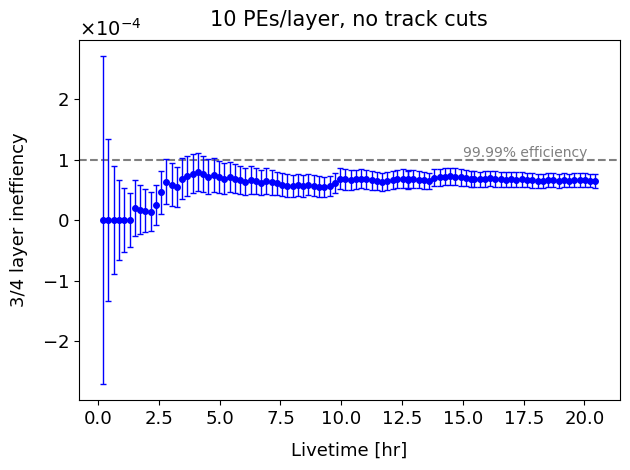

---> Written scatter.png


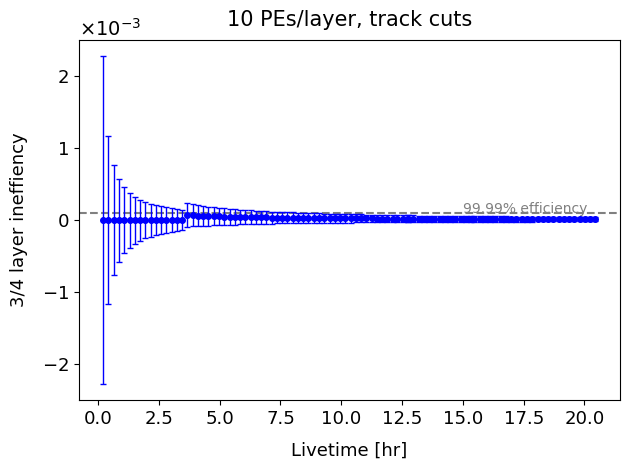

---> Written scatter.png
---> Written scatter.png


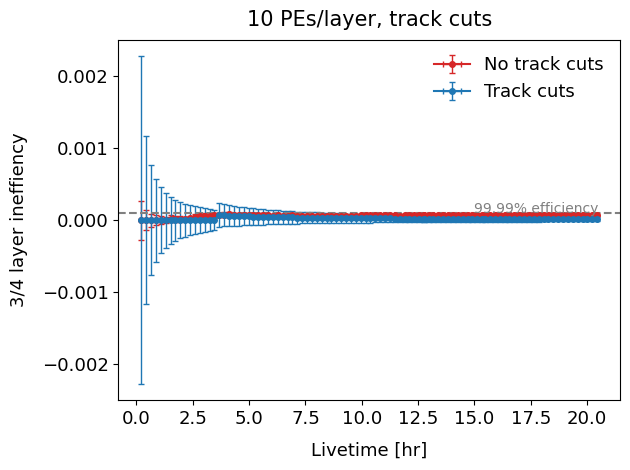

In [89]:
# Uncertainties
# I think a conservative Wilson estimate is the best bet. 
# The other three look remarkably similar, and return zero uncertainty at low N and zero k, which is just a bad estimate.

def PoissonUncertainty(data_):
    n_failures = data_["running_failures"]
    n_total = data_["running_total"]
    return np.sqrt(n_failures) / (n_total)

def BinomialUncertainty(data_):
    # What happens if the number of failures gets close to zero?
    n_failures = data_["running_failures"]
    n_total = data_["running_total"]
    q = n_failures / n_total # binomial
    se_q = np.sqrt(q * (1 - q) / n_total)
    return se_q

from statsmodels.stats.proportion import proportion_confint
def WilsonUncertainty(data_, conservative=True):
    # What happens if the number of failures gets close to zero?
    k = data_["running_failures"]
    N = data_["running_total"]
    lower, upper = proportion_confint(k, N, method="wilson")
    point = k/N
    if conservative: 
        return abs((upper - point) / 2)
    else:
        return abs((lower - point) / 2)

# PlotGraphErrors(x=(data_["running_livetime"]/3600)
#                 , y=(data_["running_failures"]/data_["running_total"])
#                 # , yerr=np.sqrt(data_["running_failures"]) / (data_["running_total"]) # Poisson
#                 , yerr=BinomialUncertainty(data_) 
#                 , xlabel="Livetime [hr]", ylabel=f"{layer}/4 layer ineffiency")

# PlotGraphErrors(x=(data_["running_livetime"]/3600)
#                 , y=(data_["running_failures"]/data_["running_total"])
#                 # , yerr=np.sqrt(data_["running_failures"]) / (data_["running_total"]) # Poisson
#                 , yerr=PoissonUncertainty(data_) 
#                 , xlabel="Livetime [hr]", ylabel=f"{layer}/4 layer ineffiency")

PlotGraphErrors(x=(data_no_track_cuts_["running_livetime"]/3600)
                , y=(data_no_track_cuts_["running_failures"]/data_no_track_cuts_["running_total"])
                # , yerr=np.sqrt(data_["running_failures"]) / (data_["running_total"]) # Poisson
                , yerr=WilsonUncertainty(data_no_track_cuts_, conservative=True) 
                , colour=ut.colours[1]
                , xlabel="Livetime [hr]"
                , ylabel=f"{layer}/4 layer ineffiency"
                , title=f"{PEs} PEs/layer, no track cuts")

PlotGraphErrors(x=(data_track_cuts_["running_livetime"]/3600)
                , y=(data_track_cuts_["running_failures"]/data_track_cuts_["running_total"])
                # , yerr=np.sqrt(data_["running_failures"]) / (data_["running_total"]) # Poisson
                , yerr=WilsonUncertainty(data_track_cuts_, conservative=True) 
                , colour=ut.colours[2]
                , xlabel="Livetime [hr]"
                , ylabel=f"{layer}/4 layer ineffiency"
                , title=f"{PEs} PEs/layer, track cuts")

graphs_ = { "No track cuts" : 
           { "x" : data_no_track_cuts_["running_livetime"]/3600
            , "xerr" : [0]*len(data_no_track_cuts_["running_livetime"])
            , "y" : data_no_track_cuts_["running_failures"]/data_no_track_cuts_["running_total"]
            , "yerr" : WilsonUncertainty(data_no_track_cuts_, conservative=True) } 
           , "Track cuts" : 
           { "x" : data_track_cuts_["running_livetime"]/3600
            , "xerr" : [0]*len(data_track_cuts_["running_livetime"])
            , "y" : data_track_cuts_["running_failures"]/data_track_cuts_["running_total"]
            , "yerr" : WilsonUncertainty(data_track_cuts_, conservative=True) } 
          }
           


PlotGraphOverlay(graphs_
                , xlabel="Livetime [hr]"
                , ylabel=f"{layer}/4 layer ineffiency"
                , title=f"{PEs} PEs/layer, track cuts"
                , effLine=True)
# PlotGraphErrors(x=(data_["running_livetime"]/3600)
#                 , y=(data_["running_failures"]/data_["running_total"])
#                 # , yerr=np.sqrt(data_["running_failures"]) / (data_["running_total"]) # Poisson
#                 , yerr=WilsonUncertainty(data_, conservative=False) 
#                 , xlabel="Livetime [hr]", ylabel=f"{layer}/4 layer ineffiency")


In [7]:
# '''
# Get failure info
# For each file, collect the events. 

# This takes quite a while (2-3 minutes maybe).
# I spent a full day trying to multithread this, it blows up my memory. 
# '''
# def GetFailures(fileList_, PEs=10, layers="3", particle="all", cut="singles"):

#      # Collect failure info
#     failureFilePath = f"../Txt/MDC2020ae/concatenated/failures_concise/failures_concise_all_{PEs}PEs{layers}Layers_{cut}.csv"

#     print(f"\n---> Using info file {failureFilePath}.")
#     failureInfo_ = pd.read_csv(failureFilePath)

#     # Collect file list
#     tags_ = list(set(failureInfo_["tag"]))
    
#     # Extract the tag from the file name
#     def ExtractTag(fileName):
#         parts = fileName.split('.')
#         if len(parts) > 1:
#             return parts[-2]
#         return None

#     # Filter and sort files based on tags
#     fileList_ = sorted(
#         [file for file in fileList_ if ExtractTag(file) in tags_]
#         , key=lambda file: tags_.index(ExtractTag(file))
#     )

#     # testing
#     # tags_ = tags_[:1]
#     # fileList_ = fileList_[:1]
    
#     # Bug check
#     if len(fileList_) == len(tags_):
#         print("\n---> Collected and sorted failure file names.")
#     else:
#         raise Exception("\n---> len(fileList_) != len(tags_)")

#     completedFiles = 0
#     totalFiles = len(fileList_)

#     print(f"\n---> Iterating through {len(fileList_)} files.\n") 

#     # Master array to hold results
#     data_ = ak.Array([])
    
#     # Iterate through file list.
#     for tag, fileName in zip(tags_, fileList_): 
    
#         # Find failure events
#         thisFailureInfo_ = failureInfo_[failureInfo_["tag"] == tag]
#         outputStr = ( 
#             f"\n--->\n" 
#             f"fileName: {fileName}\n"
#             f"tag: {tag}\n"
#             f"failures:\n{thisFailureInfo_}\n"
#             f"---"
#         )
#         if False: print(outputStr)
    
#         # Read the file
#         with uproot.open(fileName) as file: 
            
#             # file = (fileName, quiet=True)
#             # Get array
#             thisData_ = ut.GetData(file)
        
#             if False: print(f"\n---> Loaded corresponding data.\n{thisData_}")
                
#             if False: print(f"\n---> Applying masks.")
        
#             # Extract unique values from DataFrame
#             runs_ = set(thisFailureInfo_["evtinfo.run"])
#             subruns_ = set(thisFailureInfo_["evtinfo.subrun"])
#             events_ = set(thisFailureInfo_["evtinfo.event"])
        
#             # Construct masks
#             runCondition = ak.any([thisData_["evt"]["evtinfo.run"] == value for value in runs_], axis=0)
#             subrunCondition = ak.any([thisData_["evt"]["evtinfo.subrun"] == value for value in subruns_], axis=0)
#             eventCondition = ak.any([thisData_["evt"]["evtinfo.event"] == value for value in events_], axis=0)
        
#             # Apply masks
#             thisData_ = thisData_[runCondition & subrunCondition & eventCondition]
        
#             # Append to master array
#             if False: print(f"\n---> Appending failures to master array.")
#             data_ = ak.concatenate([data_, thisData_], axis=0)

#             if False:
#                 print(thisFailureInfo_)
#                 ut.PrintNEvents(data_)
    
#             completedFiles += 1
#             percentComplete = (completedFiles / totalFiles) * 100
            
#             print(f"\r---> Processed {fileName} ({percentComplete:.1f}% complete...)", end="") 

#     inputEventList = failureInfo_["evtinfo.event"]
#     outputEventList = ak.flatten(data_["evt"]["evtinfo.event"], axis=None)

#     return data_